## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
import os, sys
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))

/Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models


In [3]:
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from datasets import load_from_disk

import matplotlib.pyplot as plt
import seaborn as sns

from evaluation.string_edit_metrics import get_string_edit_metrics, get_string_edit_metrics_ortho_and_norm
from normalization.whisper_normalization import get_whisper_normalizer
from utils.whisper_hallucinations.eval_filter_criterion import eval_filter_criterion
from utils.whisper_hallucinations.get_features import compute_gzip_compression_ratio
from utils.notebook_utils import listen_to_audio

whisper_norm = get_whisper_normalizer("english")
sns.set_theme(context="paper", style="ticks")

OUTPUT_DIR = Path("notebooks/outputs/")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

## Load cached dataset

In [4]:
dataset_name = "ami_validation"

savepath = f"notebooks/data/whisper_hallucinations_cached_ds/{dataset_name}"
ds = load_from_disk(savepath)

ds.features

{'text': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'teacher_text': Value(dtype='string', id=None),
 'teacher_labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'audio_length': Value(dtype='float64', id=None),
 'n_tokens_labels': Value(dtype='int64', id=None),
 'n_tokens_teacher': Value(dtype='int64', id=None),
 'diff_n_tokens': Value(dtype='int64', id=None),
 'gzip_ratio': Value(dtype='float64', id=None),
 'teacher_gzip_ratio': Value(dtype='float64', id=None),
 'diff_gzip_ratio': Value(dtype='float64', id=None),
 'n_overlaps': Value(dtype='int64', id=None)}

## Convert to DataFrame

In [5]:
df = pd.DataFrame({col: ds[col] for col in ds.features.keys() if col != "audio"})

df.head()

,text,labels,teacher_text,teacher_labels,audio_length,n_tokens_labels,n_tokens_teacher,diff_n_tokens,gzip_ratio,teacher_gzip_ratio,diff_gzip_ratio,n_overlaps
0,but like mobile phones have screens and they'r...,"[50258, 50363, 5955, 411, 6013, 10216, 362, 11...",But like mobile phones have screens and they'...,"[50258, 50363, 583, 411, 6013, 10216, 362, 111...",2.68,14,15,1,0.757143,0.743243,-0.013900,0
1,mm,"[50258, 50363, 2174, 50257]",you,"[50258, 50363, 291, 50257]",0.15,4,4,0,0.090909,0.166667,0.075758,0
2,furry,"[50258, 50363, 69, 30614, 50257]",furry.,"[50258, 50363, 47073, 13, 50257]",0.52,5,5,0,0.200000,0.259259,0.059259,0
3,yeah,"[50258, 50363, 19650, 50257]",Yeah.,"[50258, 50363, 865, 13, 50257]",1.86,4,5,1,0.166667,0.230769,0.064103,0
4,i mean it just seems like yeah,"[50258, 50363, 72, 914, 309, 445, 2544, 411, 1...",I mean it just seems like... Yeah.,"[50258, 50363, 286, 914, 309, 445, 2544, 411, ...",2.27,10,12,2,0.600000,0.636364,0.036364,0


## First analysis

In [6]:
dict_string_edit_metrics = get_string_edit_metrics_ortho_and_norm(references=df["text"], predictions=df["teacher_text"], norm_fn=get_whisper_normalizer("english"))

dict_string_edit_metrics

{'WER ortho (%)': 46.33450233273304,
 'Sub ortho (%)': 31.775720619674996,
 'Del ortho (%)': 11.933272250481817,
 'Ins ortho (%)': 2.625509462576222,
 'WER (%)': 18.36682750941195,
 'Sub (%)': 6.105307810594411,
 'Del (%)': 8.533856514131184,
 'Ins (%)': 3.727663184686357}

**Observation:** Using the Whisper normalizer drastically decreased the different string edit metric errors. Since 1-best operated without any normalization, we will focus on the orthographic WER in this study.

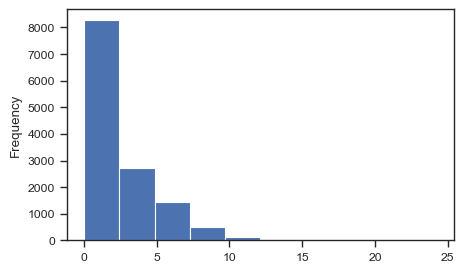

In [7]:
plt.figure(figsize=(5, 3))
df["audio_length"].plot.hist();

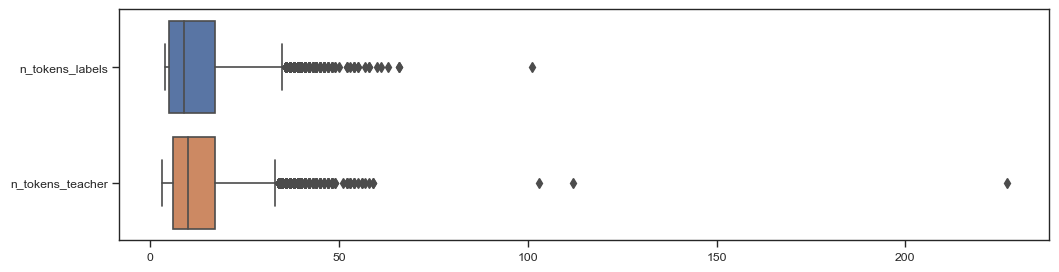

In [8]:
plt.figure(figsize=(12, 3))
sns.boxplot(data=df[["n_tokens_labels", "n_tokens_teacher"]], orient="h");

Figure saved at `notebooks/outputs/text_based/n_diff_tokens/n_tokens_teacher_wrt_n_tokens_label.png`.


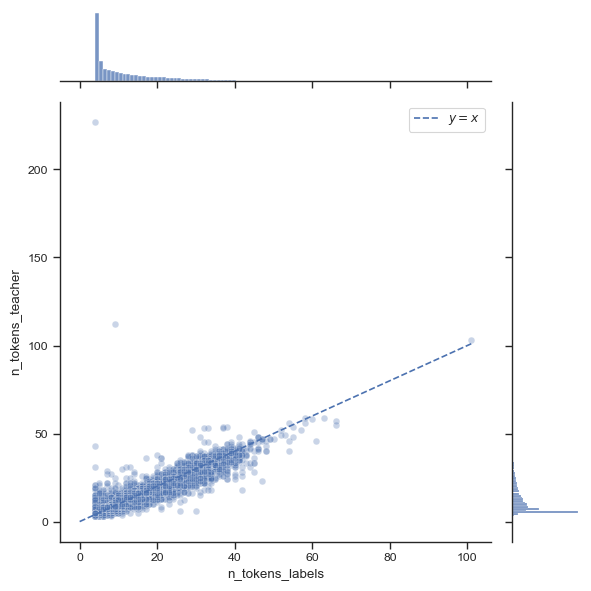

In [9]:
x_col = "n_tokens_labels"
y_col = "n_tokens_teacher"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, line_max_coord], [0, line_max_coord], 'b--', label=r"$y=x$")
plt.legend()
plt.tight_layout()

savepath = OUTPUT_DIR / "text_based" / "n_diff_tokens" / "n_tokens_teacher_wrt_n_tokens_label.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

Figure saved at `notebooks/outputs/text_based/n_diff_tokens/boxplot_n_diff_tokens.png`.


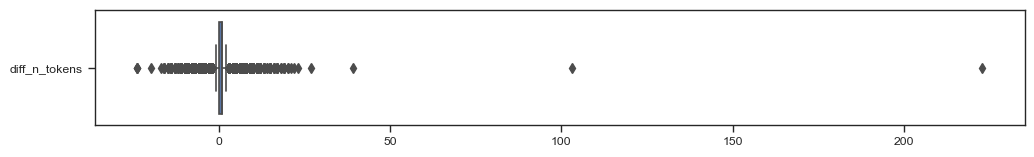

In [10]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_n_tokens"]], orient="h")

savepath = OUTPUT_DIR / "text_based" / "n_diff_tokens" / "boxplot_n_diff_tokens.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

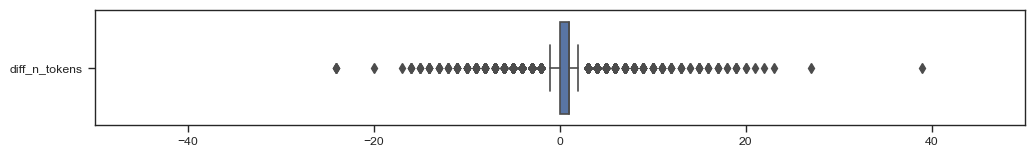

In [11]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_n_tokens"]], orient="h")
plt.xlim(-50, 50);

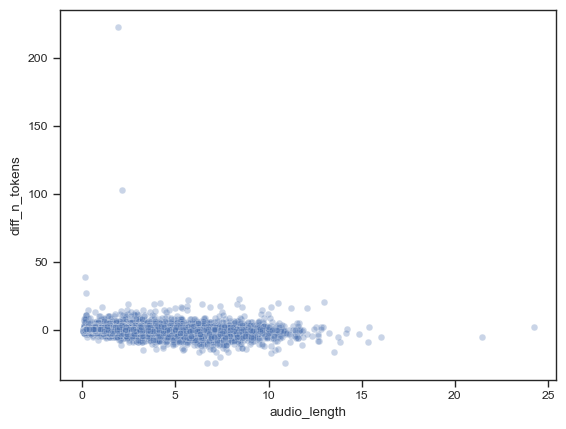

In [12]:
sns.scatterplot(data=df, x="audio_length", y="diff_n_tokens", alpha=0.3);

Figure saved at `notebooks/outputs/preliminary/n_tokens_wrt_audio_length.png`.


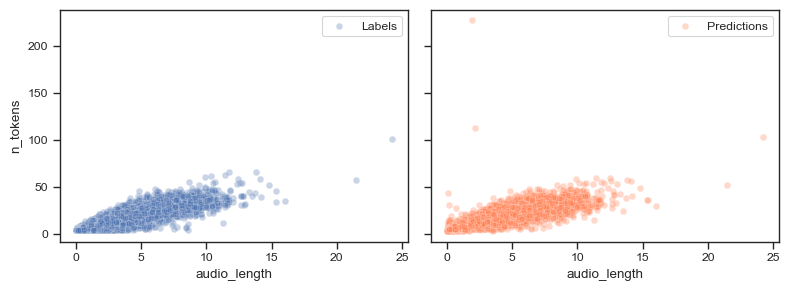

In [13]:
fig, axis = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
sns.scatterplot(data=df, x="audio_length", y="n_tokens_labels", label="Labels", alpha=0.3, ax=axis[0])
sns.scatterplot(data=df, x="audio_length", y="n_tokens_teacher", label="Predictions", c="coral", alpha=0.3, ax=axis[1])
axis[0].set_ylabel("n_tokens")
fig.tight_layout()

savepath = OUTPUT_DIR / "preliminary" / "n_tokens_wrt_audio_length.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

## Criteria for filtering

### Difference in number of tokens

In [14]:
THRESH_DELTA_N_TOKENS = int(df["diff_n_tokens"].mean() + 1.5 * df["diff_n_tokens"].std())
THRESH_DELTA_N_TOKENS

5

Figure saved at `notebooks/outputs/text_based/n_diff_tokens/n_diff_tokens_filter_pairplot.png`.


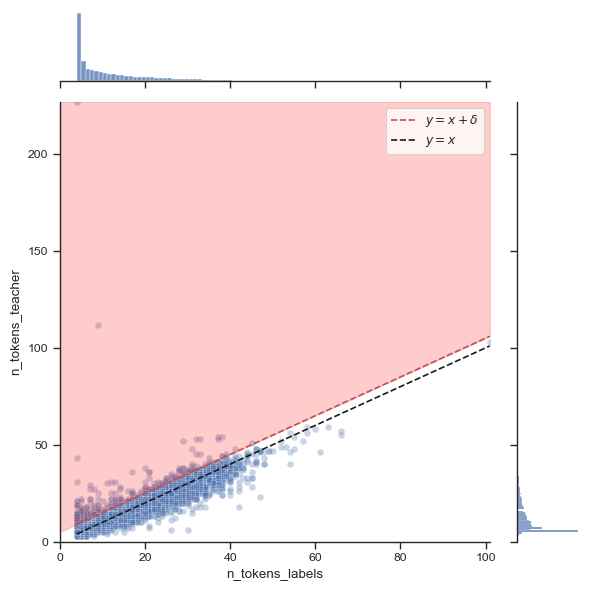

In [15]:
# Define the columns to use for the plot
x_col = "n_tokens_labels"
y_col = "n_tokens_teacher"

# Define the value of delta
delta = THRESH_DELTA_N_TOKENS

# Create the joint plot
sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)

# Plot the line y = x + delta
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min() + delta, df[x_col].max() + delta], 'r--', label=r"$y = x + \delta$")

# Fill the area above the line y = x + delta
plt.fill_between([0, df[x_col].max()],
                 [0 + delta, df[x_col].max() + delta], df[y_col].max(),
                 alpha=0.2,
                 color="red")

# Plot the line y = x
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min(), df[x_col].max()], 'k--', label=r"$y = x$")

# Add legend and set axis limits
plt.legend()
plt.xlim(0, df[x_col].max())
plt.ylim(0, df[y_col].max())

# Adjust the layout and show the plot
plt.tight_layout()

# Save figure
savepath = OUTPUT_DIR / "text_based" / "n_diff_tokens" / "n_diff_tokens_filter_pairplot.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

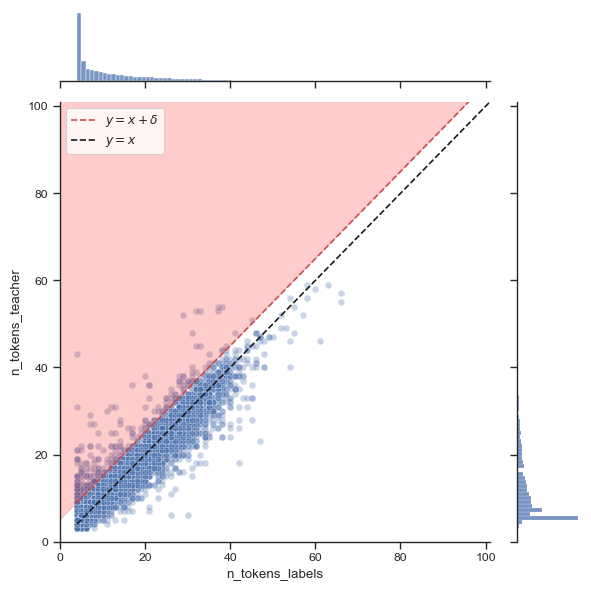

In [16]:
# Define the columns to use for the plot
x_col = "n_tokens_labels"
y_col = "n_tokens_teacher"

# Define the value of delta
delta = THRESH_DELTA_N_TOKENS

# Create the joint plot
sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)

# Plot the line y = x + delta
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min() + delta, df[x_col].max() + delta], 'r--', label=r"$y = x + \delta$")

# Fill the area above the line y = x + delta
plt.fill_between([0, df[x_col].max()],
                 [0 + delta, df[x_col].max() + delta], df[y_col].max(),
                 alpha=0.2,
                 color="red")

# Plot the line y = x
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min(), df[x_col].max()], 'k--', label=r"$y = x$")

# Add legend and set axis limits
plt.legend()
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.xlim(0, line_max_coord)
plt.ylim(0, line_max_coord)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Figure saved at `notebooks/outputs/text_based/n_diff_tokens/n_diff_tokens_filter_hist.png`.


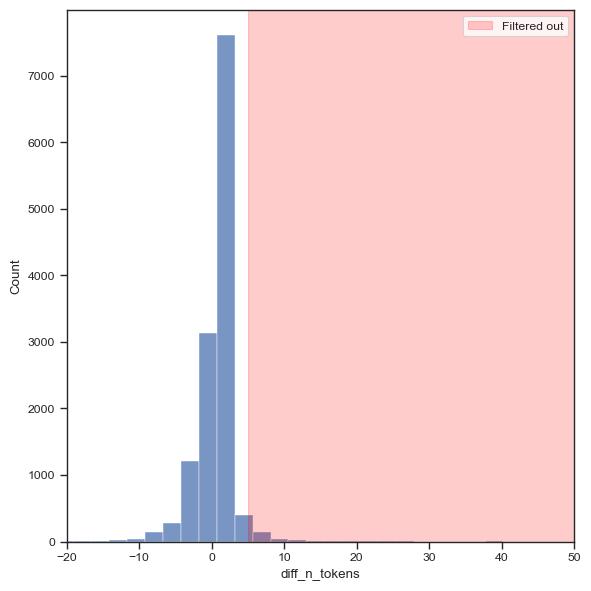

In [17]:
plt.figure(figsize=(6, 6))

# create a histogram of the "diff_n_tokens" column
sns.histplot(data=df, x="diff_n_tokens", bins=100)

# shade the area that will be filtered out in red
plt.axvspan(THRESH_DELTA_N_TOKENS, df["diff_n_tokens"].max(), color='red', alpha=0.2, label="Filtered out")

plt.legend()
plt.xlim(-20, 50)

# show the plot
plt.tight_layout()

# Save figure
savepath = OUTPUT_DIR / "text_based" / "n_diff_tokens" / "n_diff_tokens_filter_hist.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

In [18]:
df["high_diff_n_tokens"] = (df["diff_n_tokens"] > THRESH_DELTA_N_TOKENS)

df["high_diff_n_tokens"].value_counts()

False    12861
True       237
Name: high_diff_n_tokens, dtype: int64

In [19]:
df_candidates = df[df["high_diff_n_tokens"]]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 59
Reference:  um oh we just
Prediction:   Um, I will just have to zoom.

Idx = 99
Reference:  this is yeah well like a cat you know soft yeah
Prediction:   Yeah, well, like a cat, you know. Soft, yeah. Ha ha.

Idx = 298
Reference:  i don't yeah i mean it but like i mean just i mean like your phone even just has so like it can vibrate
Prediction:   I don't, yeah, I mean, but like, I mean, just, I mean, like your phone even just has sound, like it can vibrate.

Idx = 324
Reference:  but even just a thing to attach it to the w you know if you had a thing a pretty object attached to the wall
Prediction:   But even just a thing to attach it to the wall. You know, if you had a thing, a pretty object, to attach it to the wall.

Idx = 463
Reference:  what if yeah what if the squishy oh so so you're saying the squishy part's like detachable
Prediction:   What if, yeah, what if the squishy, oh, sorry, so you're saying the squishy part's like detachable?

Idx = 533
Reference:  so anyway if

In [20]:
list_idx_to_listen = df_candidates.index[:5]

listen_to_audio(ds, list_idx_to_listen, pred_col="teacher_text")

Idx: 59
Reference: um oh we just
Prediction:  Um, I will just have to zoom.



Idx: 99
Reference: this is yeah well like a cat you know soft yeah
Prediction:  Yeah, well, like a cat, you know. Soft, yeah. Ha ha.



Idx: 298
Reference: i don't yeah i mean it but like i mean just i mean like your phone even just has so like it can vibrate
Prediction:  I don't, yeah, I mean, but like, I mean, just, I mean, like your phone even just has sound, like it can vibrate.



Idx: 324
Reference: but even just a thing to attach it to the w you know if you had a thing a pretty object attached to the wall
Prediction:  But even just a thing to attach it to the wall. You know, if you had a thing, a pretty object, to attach it to the wall.



Idx: 463
Reference: what if yeah what if the squishy oh so so you're saying the squishy part's like detachable
Prediction:  What if, yeah, what if the squishy, oh, sorry, so you're saying the squishy part's like detachable?


In [21]:
eval_filter_criterion(ds, filter_fn=lambda x: x["diff_n_tokens"] <= THRESH_DELTA_N_TOKENS)

Loading cached processed dataset at /Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models/notebooks/data/whisper_hallucinations_cached_ds/ami_validation/cache-48b2b9311eb4b503.arrow


Number of rows before filtering: 13098
Total audio length before filtering: 536.51 minutes
String edit metrics before filtering:
{'Del (%)': 8.53,
 'Del ortho (%)': 11.93,
 'Ins (%)': 3.73,
 'Ins ortho (%)': 2.63,
 'Sub (%)': 6.11,
 'Sub ortho (%)': 31.78,
 'WER (%)': 18.37,
 'WER ortho (%)': 46.33}

Number of rows after filtering: 12861
Total audio length after filtering: 520.40 minutes
String edit metrics after filtering:
{'Del (%)': 8.68,
 'Del ortho (%)': 12.15,
 'Ins (%)': 2.54,
 'Ins ortho (%)': 1.48,
 'Sub (%)': 5.9,
 'Sub ortho (%)': 31.41,
 'WER (%)': 17.11,
 'WER ortho (%)': 45.04}

Number of rows removed: 237 (1.81 %)
Total audio length removed: 16.10 minutes (3.00 %)
String edit metrics difference:
{'Del (%)': -0.15,
 'Del ortho (%)': -0.22,
 'Ins (%)': 1.19,
 'Ins ortho (%)': 1.15,
 'Sub (%)': 0.21,
 'Sub ortho (%)': 0.37,
 'WER (%)': 1.26,
 'WER ortho (%)': 1.29}

Relative string edit metrics difference:
{'Del (%)': -0.02,
 'Del ortho (%)': -0.02,
 'Ins (%)': 0.32,
 'Ins 

**Observation:** Good criterion. Note that this also tackles the fact that the vanilla Whisper models tend to transcribe even the speeches in the background. By removing them from the training set, we hope to teach Whisper to only focus on the main speaker.

### gzip compression ratio

In [22]:
# Quick example to confirm the intuition:
ref = "yeah so uh what we'll do is uh"
pred = "So, what we will do is, we will do is, we will do is, we will do is, we will do is,"

print("gzip ratios:")
print("- reference: ", compute_gzip_compression_ratio(ref))
print("- prediction: ", compute_gzip_compression_ratio(pred))

gzip ratios:
- reference:  0.6122448979591837
- prediction:  1.8444444444444446


In [23]:
df.columns

Index(['text', 'labels', 'teacher_text', 'teacher_labels', 'audio_length',
       'n_tokens_labels', 'n_tokens_teacher', 'diff_n_tokens', 'gzip_ratio',
       'teacher_gzip_ratio', 'diff_gzip_ratio', 'n_overlaps',
       'high_diff_n_tokens'],
      dtype='object')

Figure saved at `notebooks/outputs/text_based/gzip_ratio/pairplot_gzip.png`.


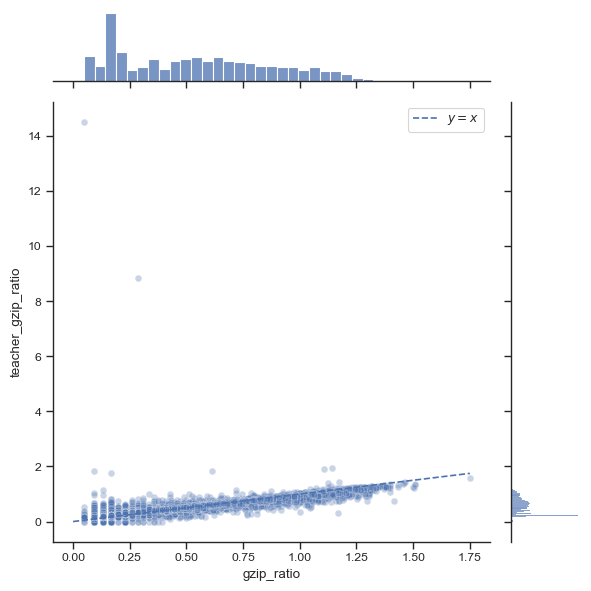

In [24]:
x_col = "gzip_ratio"
y_col = "teacher_gzip_ratio"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, line_max_coord], [0, line_max_coord], 'b--', label=r"$y=x$")
plt.legend()
# plt.xlim(-1, line_max_coord)
# plt.ylim(-1, line_max_coord)
plt.tight_layout()

savepath = OUTPUT_DIR / "text_based" / "gzip_ratio" / "pairplot_gzip.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

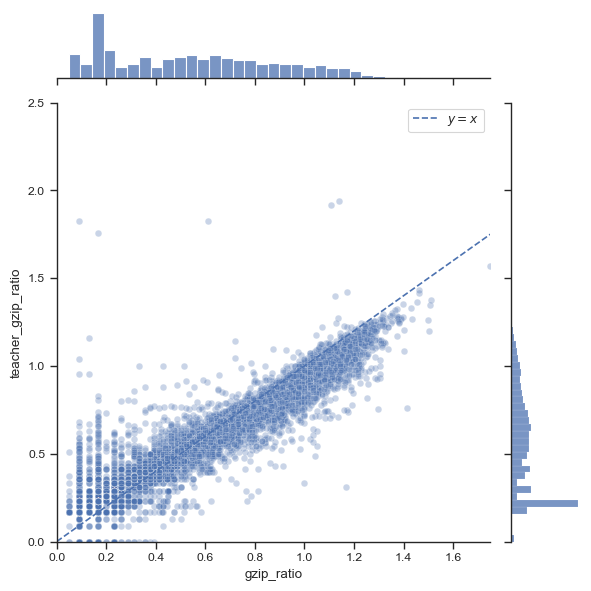

In [25]:
x_col = "gzip_ratio"
y_col = "teacher_gzip_ratio"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, line_max_coord], [0, line_max_coord], 'b--', label=r"$y=x$")
plt.legend()
plt.xlim(0, line_max_coord)
plt.ylim(0, 2.5)
plt.tight_layout()

Figure saved at `notebooks/outputs/text_based/gzip_ratio/boxplot_gzip_ratio.png`.


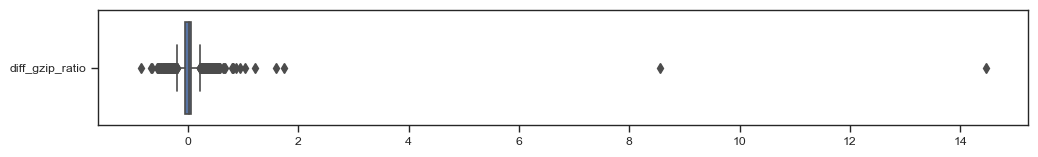

In [26]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_gzip_ratio"]], orient="h")

# Save figure:
savepath = OUTPUT_DIR / "text_based" / "gzip_ratio" / "boxplot_gzip_ratio.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

In [27]:
THRESH_DIFF_GZIP = df["diff_gzip_ratio"].mean() + 1.5 * df["diff_gzip_ratio"].std()

THRESH_DIFF_GZIP

0.27442696695645585

Figure saved at `notebooks/outputs/text_based/gzip_ratio/pairplot_gzip_filter.png`.


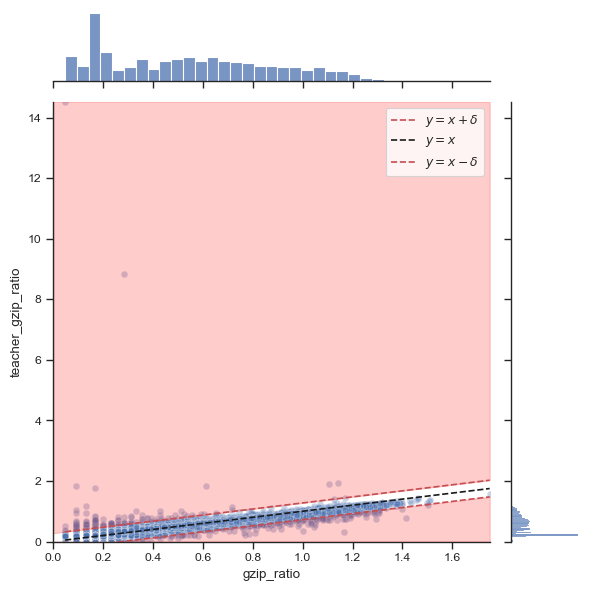

In [28]:
# Define the columns to use for the plot
x_col = "gzip_ratio"
y_col = "teacher_gzip_ratio"


# Define the value of delta
delta = THRESH_DIFF_GZIP

# Create the joint plot
sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)

# Plot the line y = x + delta
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min() + delta, df[x_col].max() + delta], 'r--', label=r"$y = x + \delta$")

# Fill the area above the line y = x + delta
plt.fill_between([0, df[x_col].max()],
                 [0 + delta, df[x_col].max() + delta], df[y_col].max(),
                 alpha=0.2,
                 color="red")

# Plot the line y = x
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min(), df[x_col].max()], 'k--', label=r"$y = x$")

# Plot the line y = x - delta
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min() - delta, df[x_col].max() - delta], 'r--', label=r"$y = x - \delta$")

# Fill the area below the line y = x - delta
plt.fill_between([0, df[x_col].max()],
                 [0 - delta, df[x_col].max() - delta], df[y_col].min(),
                 alpha=0.2,
                 color="red")

# Add legend and set axis limits
plt.legend()
plt.xlim(0, df[x_col].max())
plt.ylim(0, df[y_col].max())

# Adjust the layout and show the plot
plt.tight_layout()

# Save figure:
savepath = OUTPUT_DIR / "text_based" / "gzip_ratio" / "pairplot_gzip_filter.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

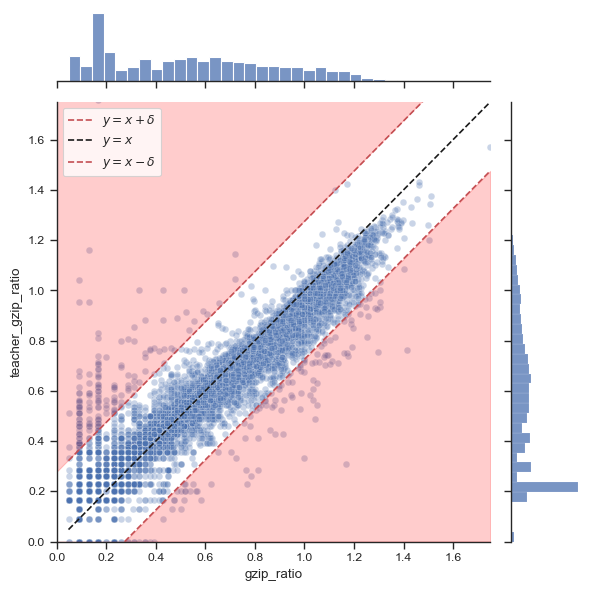

In [29]:
# Define the columns to use for the plot
x_col = "gzip_ratio"
y_col = "teacher_gzip_ratio"


# Define the value of delta
delta = THRESH_DIFF_GZIP

# Create the joint plot
sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)

# Plot the line y = x + delta
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min() + delta, df[x_col].max() + delta], 'r--', label=r"$y = x + \delta$")

# Fill the area above the line y = x + delta
plt.fill_between([0, df[x_col].max()],
                 [0 + delta, df[x_col].max() + delta], df[y_col].max(),
                 alpha=0.2,
                 color="red")

# Plot the line y = x
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min(), df[x_col].max()], 'k--', label=r"$y = x$")

# Plot the line y = x - delta
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min() - delta, df[x_col].max() - delta], 'r--', label=r"$y = x - \delta$")

# Fill the area below the line y = x - delta
plt.fill_between([0, df[x_col].max()],
                 [0 - delta, df[x_col].max() - delta], df[y_col].min(),
                 alpha=0.2,
                 color="red")

# Add legend and set axis limits
plt.legend()
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.xlim(0, line_max_coord)
plt.ylim(0, line_max_coord)

# Adjust the layout and show the plot
plt.tight_layout()

Figure saved at `notebooks/outputs/text_based/gzip_ratio/hist_gzip_filter.png`.


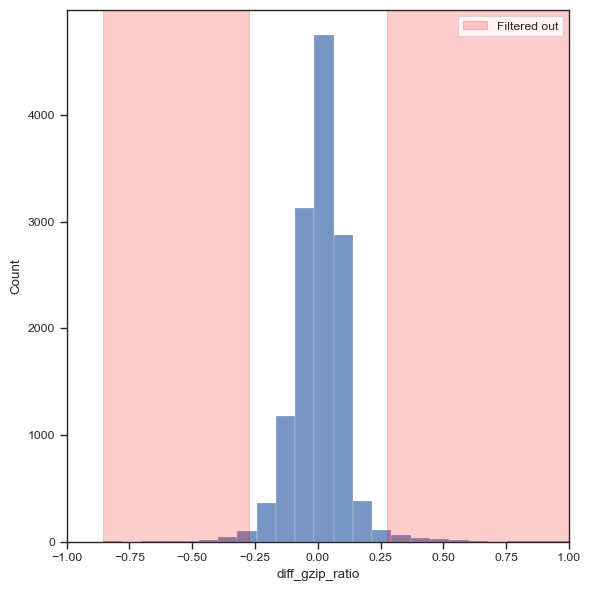

In [30]:
plt.figure(figsize=(6, 6))

# create a histogram of the "diff_n_tokens" column
sns.histplot(data=df, x="diff_gzip_ratio", bins=200)

# shade the area that will be filtered out in red
plt.axvspan(THRESH_DIFF_GZIP, df["diff_gzip_ratio"].max(), color='red', alpha=0.2, label="Filtered out")
plt.axvspan(-THRESH_DIFF_GZIP, df["diff_gzip_ratio"].min(), color='red', alpha=0.2)

plt.legend()
plt.xlim(-1, 1)

# show the plot
plt.tight_layout()

# Save figure:
savepath = OUTPUT_DIR / "text_based" / "gzip_ratio" / "hist_gzip_filter.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

In [31]:
df_candidates = df[df["diff_gzip_ratio"] > THRESH_DIFF_GZIP]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 749
Reference:  yeah
Prediction:   Thank you. Thank you.

Idx = 841
Reference:  uh
Prediction:   So, thank you.

Idx = 988
Reference:  that's
Prediction:   That's what though.

Idx = 1044
Reference:  mm
Prediction:   some people.

Idx = 1072
Reference:  two
Prediction:   and we'll be right back.

Idx = 1111
Reference:  okay
Prediction:   Okay. Yeah, that's what I'm talking about.

Idx = 1340
Reference:  ah okay
Prediction:   Ah, okay. Sorry, I should have explained that.

Idx = 1343
Reference:  mm mm
Prediction:   and then it's like, yeah.

Idx = 1357
Reference:  mm-hmm
Prediction:   Mm-hmm. Ha ha ha.

Idx = 1380
Reference:  rooms yeah
Prediction:   The three person rooms. The three person rooms, yeah.

Idx = 1427
Reference:  yeah
Prediction:   Assuming you figured out, but just in case.

Idx = 1494
Reference:  yeah mm mm
Prediction:   Yeah. It's the same thing for the professor.

Idx = 1689
Reference:  yep
Prediction:   So about two o'clock?

Idx = 1736
Reference:  yeah
Predicti

In [32]:
df_candidates = df[df["diff_gzip_ratio"] < - THRESH_DIFF_GZIP]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 257
Reference:  or like you h you see those you know people i'm thinking of like celebrity cribs kind of things when like they have all those these things that at their house you know their their entire house is so electronic
Prediction:   You see those people, I'm thinking of celebrity cribs kind of things, when they have all these things at their house. Their entire house is so electronic.

Idx = 616
Reference:  say that's the s say that's the squashy bit
Prediction:   Say that's the squashy bit.

Idx = 639
Reference:  i mean i think uh and i think the handhe i think the handheld part is definitely
Prediction:   I mean, I think the hand-held part is definitely...

Idx = 816
Reference:  yeah yeah yeah
Prediction:   Yeah

Idx = 831
Reference:  yeah like you're g yeah like you're gonna have to be able to switch to like a mode where you can okay we're not choosing that i guess
Prediction:   Yeah, like you're going to have to be able to switch to a mode. OK, well, not choosing that,

In [33]:
eval_filter_criterion(ds, filter_fn=lambda x: np.abs(x["diff_gzip_ratio"]) <= THRESH_DIFF_GZIP)

Loading cached processed dataset at /Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models/notebooks/data/whisper_hallucinations_cached_ds/ami_validation/cache-df672cbf775069c5.arrow


Number of rows before filtering: 13098
Total audio length before filtering: 536.51 minutes
String edit metrics before filtering:
{'Del (%)': 8.53,
 'Del ortho (%)': 11.93,
 'Ins (%)': 3.73,
 'Ins ortho (%)': 2.63,
 'Sub (%)': 6.11,
 'Sub ortho (%)': 31.78,
 'WER (%)': 18.37,
 'WER ortho (%)': 46.33}

Number of rows after filtering: 12807
Total audio length after filtering: 522.74 minutes
String edit metrics after filtering:
{'Del (%)': 7.93,
 'Del ortho (%)': 11.3,
 'Ins (%)': 2.93,
 'Ins ortho (%)': 1.78,
 'Sub (%)': 6.01,
 'Sub ortho (%)': 31.85,
 'WER (%)': 16.87,
 'WER ortho (%)': 44.92}

Number of rows removed: 291 (2.22 %)
Total audio length removed: 13.77 minutes (2.57 %)
String edit metrics difference:
{'Del (%)': 0.6,
 'Del ortho (%)': 0.63,
 'Ins (%)': 0.8,
 'Ins ortho (%)': 0.85,
 'Sub (%)': 0.1,
 'Sub ortho (%)': -0.07,
 'WER (%)': 1.5,
 'WER ortho (%)': 1.41}

Relative string edit metrics difference:
{'Del (%)': 0.07,
 'Del ortho (%)': 0.05,
 'Ins (%)': 0.21,
 'Ins ortho (

### Timestamp overlaps

In [34]:
df["n_overlaps"].value_counts()

0    13076
1       21
2        1
Name: n_overlaps, dtype: int64

In [35]:
ds_candidate = ds.filter(lambda x: x["n_overlaps"] > 0)

for idx, row in enumerate(ds_candidate):
    print("Index: ", idx)
    print("Reference: ", row["text"])
    print("Pred: ", row["teacher_text"])
    print()

Loading cached processed dataset at /Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models/notebooks/data/whisper_hallucinations_cached_ds/ami_validation/cache-134a3ff9d59ff9ea.arrow


Index:  0
Reference:  no uh automatic uh coffee machines
Pred:   Now, automatic coffee machines.

Index:  1
Reference:  mm
Pred:   and I'm not sure if it's But I think it's because of And I think it's because of And I think it's because of And I think it's because of

Index:  2
Reference:  oh all okay all of us
Pred:   Oh, okay, all of us.

Index:  3
Reference:  yeah just is that okay
Pred:   Yeah, just, is that okay?

Index:  4
Reference:  wha what um well probably our target group and how it's gonna going to appeal to our target group and i dunno the the s the buttons and what it does and that sort of thing
Pred:   what, well probably our target group and how it's going to appeal to our target group in, I don't know, the buttons and what it does and that sort of thing.

Index:  5
Reference:  like uh we could do i'm trying to think of other sha like fruits that are oddly shaped
Pred:   Like, we could do, I'm trying to think of other shape, like fruits that are oddly shaped.

Index:  6

In [36]:
eval_filter_criterion(ds, filter_fn=lambda x: x["n_overlaps"] == 0)

Loading cached processed dataset at /Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models/notebooks/data/whisper_hallucinations_cached_ds/ami_validation/cache-37d977817519a7fd.arrow


Number of rows before filtering: 13098
Total audio length before filtering: 536.51 minutes
String edit metrics before filtering:
{'Del (%)': 8.53,
 'Del ortho (%)': 11.93,
 'Ins (%)': 3.73,
 'Ins ortho (%)': 2.63,
 'Sub (%)': 6.11,
 'Sub ortho (%)': 31.78,
 'WER (%)': 18.37,
 'WER ortho (%)': 46.33}

Number of rows after filtering: 13076
Total audio length after filtering: 534.52 minutes
String edit metrics after filtering:
{'Del (%)': 8.54,
 'Del ortho (%)': 11.93,
 'Ins (%)': 3.67,
 'Ins ortho (%)': 2.54,
 'Sub (%)': 6.11,
 'Sub ortho (%)': 31.78,
 'WER (%)': 18.31,
 'WER ortho (%)': 46.25}

Number of rows removed: 22 (0.17 %)
Total audio length removed: 1.98 minutes (0.37 %)
String edit metrics difference:
{'Del (%)': -0.01,
 'Del ortho (%)': 0.0,
 'Ins (%)': 0.06,
 'Ins ortho (%)': 0.09,
 'Sub (%)': 0.0,
 'Sub ortho (%)': 0.0,
 'WER (%)': 0.06,
 'WER ortho (%)': 0.08}

Relative string edit metrics difference:
{'Del (%)': -0.0,
 'Del ortho (%)': 0.0,
 'Ins (%)': 0.02,
 'Ins ortho (%